# 聚类算法
> 它是一种无监督的学习方式，即只有$x$，没有$y$。所以聚类分析不能自动发现和告诉你应该分成多少个类——这也是与分类分析的差别；若样本聚类，变量之间的关系定义需要研究者决定；也不会自动给出一个最佳聚类结果，其分析的结果可以提供多个可能的解，最后结果的选择比较依赖研究者，需要研究者的主观判断和后续的分析；但它的优势在于比较简单直观，不管实际数据中是否真正存在不同的类别，利用聚类分析都能得到分成若干类别的解；
1. [Mixture Models](#ch1)
1. [K-means](#ch2)
1. [Hierarchical Clustering](#ch3)
1. [EM Clustering](#ch4)


<a id='ch1'></a>
## 1. Guassian Mixture Models(GMM)
>GMM(Gaussian Mixture Model, 高斯混合模型)是指该算法油多个高斯模型线性叠加混合而成。每个高斯模型称之为component。是EM算法的一个重要应用。

<kbd>定义</kbd>：
- $P(y\left| \theta  \right.) = \sum\limits_{k = 1}^K {{\alpha _k}\Phi \left( {y\left| {{\theta _k}} \right.} \right)} $

${{\alpha _k}}$为每个分布出现的概率，${\Phi \left( {y\left| {{\theta _k}} \right.} \right)}$为高斯分布

<kbd>步骤</kbd>：
- 1.明确隐变量，写出`完全数据`的对数似然函数

先明确`完全数据`：观测数据${y_{ij}}$（用初设的${{\alpha _k}}$生成的，是已知的）+ 反映观测数据来自哪个分模型的${\gamma _{ij}}$（取值为1或0，离散未知的），
- 2.计算EM算法中的E（即求似然的期望Q函数）
- 3.计算EM算法中的M，即求MaxQ来更新参数${{\theta _{k + 1}}}$（α,μ,σ）

*用于聚类的GMM代码：*

    from sklearn.mixture import GaussianMixture
    GaussianMixture(n_components=, covariance_type='full', random_state=0)

### 模拟GMM的实现
    参考：
[1] https://stackoverflow.com/questions/48502153/fit-mixture-of-gaussians-with-fixed-covariance-in-python

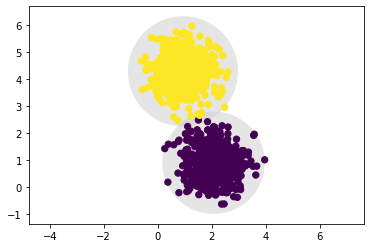

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class FixedCovMixture:
    """ The model to estimate gaussian mixture with fixed covariance matrix. """
    def __init__(self, n_components, cov, max_iter=100, random_state=None, tol=1e-10):
        self.n_components = n_components
        self.cov = cov
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol=tol

    def fit(self, X):
        # initialize the process:
        np.random.seed(self.random_state)
        n_obs, n_features = X.shape
        self.mean_ = X[np.random.choice(n_obs, size=self.n_components)]
        # make EM loop until convergence
        i = 0
        for i in range(self.max_iter):
            new_centers = self.updated_centers(X)
            if np.sum(np.abs(new_centers-self.mean_)) < self.tol:
                break
            else:
                self.mean_ = new_centers
        self.n_iter_ = i

    def updated_centers(self, X):
        """ A single iteration """
        # E-step: estimate probability of each cluster given cluster centers
        cluster_posterior = self.predict_proba(X)
        # M-step: update cluster centers as weighted average of observations
        weights = (cluster_posterior.T / cluster_posterior.sum(axis=1)).T
        new_centers = np.dot(weights, X)
        return new_centers


    def predict_proba(self, X):
        likelihood = np.stack([multivariate_normal.pdf(X, mean=center, cov=self.cov) 
                               for center in self.mean_])
        cluster_posterior = (likelihood / likelihood.sum(axis=0))
        return cluster_posterior

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0)

##拟合GMM模型
model = FixedCovMixture(2, cov=[[0.6, 0], [0, 0.6]], random_state=1)
model.fit(X)
# 绘制模拟数据在进行GMM聚类之后的散点图，以及类别的边界（以圆圈显示）
def plot_gmm(model, X, n_clusters=2, rseed=0, ax=None):
    labels = model.predict(X)

    # 绘制输入数据的散点
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # 根据不同的类别画出各个类别的边界圈
    centers = model.mean_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

plot_gmm(model, X)

<a id='ch2'></a>
##  2. K-means
> 特点：类内相似，不同聚类中对象相似度较小。
> - 最大的优势是快速和简洁。
> - 劣势是分类数k需要人为输入，且对结果会产生较大影响，K的选择方法主要是**肘部图法**
- 不足之处：只能对样本进行聚类
- 前提假设：数据独立
- 数据类型：不适合分类型数据，适合连续型数据
- 距离定义：不一定是欧式距离，只需要能够度量两个对象之间相似程度的指标都可以
- 步骤：①决定分成k群；②所有样品随机分成k群（或者直接抽出k个样品当成中心）；③算出k个群的平均值mean；④计算第i个样品离k个中心的距离，将最近的合并，并计算出新的中心点；⑤当所有样本都做过一次，且没有换中心点时，即分完。

### 模拟程序

c:\python\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


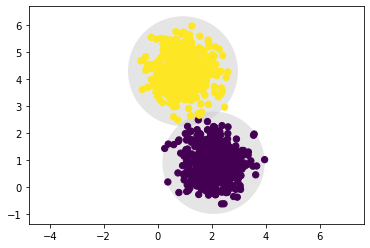

In [3]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
# 生成模拟数据1000个，设置2个类别中心
X, y_true = make_blobs(n_samples=1000, centers=2,
                       cluster_std=0.60, random_state=0)
# 定义函数：绘制模拟数据在进行K-means聚类之后的散点图，以及类别的边界（以圆圈显示）
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # 绘制输入数据的散点
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # 根据不同的类别画出各个类别的边界圈
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
# 聚类 & 绘制结果
kmeans = KMeans(n_clusters=2, random_state=0)
plot_kmeans(kmeans, X)

<a id='ch3'></a>
## 3.谱系聚类（hierarchical clustering）
> 分为自下而上聚类和自上而下聚类，层次聚类的优点是可以生成谱系图，更为直观的选择合适的类个数k；缺点：一旦两类聚在一起，就再也不能分开，且不适合大样本

<kdb>(自下而上聚类)系统聚类：</kdb>

将n个样品看成n类（一类包含一个样品），然后将性质最接近的两类合并成一个新类，得到n-1类，再从中找出最接近的两类加以合并，形成n-2类，依次进行，最后所有的样品归于一类并生成聚类图，再根据需求决定分几类

一对一时，用欧式距离，当j对k时，用以下方法：（类间距离）
- 最短距离法（群间距离最短的）——有挑选长链状聚类的倾向，不适合对分离的很差的群群体聚类
- 最长距离法（群间距离最长的）——易被异常值严重扭曲【最短、最长分群结果一致，类平均不一定】
- 类平均法（群间所有人的距离的平均）：两个类中任意两个样本之间的距离的平均（G1：1，2  G2：1，2，3 则总共有6个距离）（较好）
- 重心法——在处理异常值方面比较稳健
- 离差平方和法——对异常值较为敏感

合并群时，距离最短合并样本为群，并选定以上一种方法为原则进行分群（变量时，相关系数最大合成群）


### 案例TODO

<a id='ch4'></a>
## 4. EM算法
> 适合存在隐变量的数据，其无法通过数据概率直接计算参数的最大似然。

最大期望算法经过两个步骤交替进行计算：
- 第一步是计算期望（E），利用对隐藏变量的现有估计值，计算其最大似然估计值；（可以用该值估计某一类的条件概率）
- 第二步是最大化（M），最大化在E步上求得的最大似然值来计算参数的值。M步上找到的参数估计值被用于下一个E步计算中，这个过程不断交替进行。

<kbd>我的理解</kbd>：先随机设定待估参数初值，利用初值计算数据中隐变量的最大似然，再给定隐变量的条件下更新待估参数，继续迭代到收敛。

### 案例TODO